In [1]:
import torch
from torch import nn
from d2l import torch as d2l

#### 只有特征和参数的说法：x1*w1+x2*w2+b，x1和x2就是特征，w1和w2和b就是参数
#### 对于全连接层，我们批量归一化就是作用在特征维上，也就是对于每个x算其在所有样本上的均值和方差

#### moving_mean和moving_var是整个数据集上的均值和方差，是我们在推理的时候使用的
#### momentum是用来更新moving_mean和moving_var的，用于求moving_mean和moving_var的均值（信号与系统里面的思想）

In [10]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过torch.is_grad_enabled()来判断当前是属于训练模式还是预测模式
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) ** 2 / torch.sqrt (moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层时，计算特征维度上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层时，计算通道维上的均值和方差
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = moving_mean * momentum + mean * (1 - momentum)
        moving_var = moving_var * momentum + var * (1 - momentum)
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [14]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, x):
        if self.moving_mean.device != x.device:
            self.moving_mean = self.moving_mean.to(x.device)
            self.moving_var = self.moving_var.to(x.device)
        Y, self.moving_mean, self.moving_var = batch_norm(x, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [19]:
net  = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.268, train acc 0.901, test acc 0.099
3380.9 examples/sec on cpu


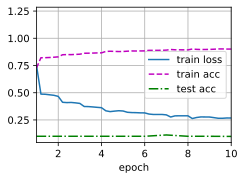

In [20]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [21]:
net[1].gamma.reshape((-1, )), net[1].beta.reshape((-1, ))

(tensor([2.6687, 1.1154, 2.6198, 4.0587, 2.6259, 2.8142],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 3.1217, -0.5267, -0.9826, -2.5027,  2.7300,  1.6554],
        grad_fn=<ReshapeAliasBackward0>))

#### 也可以调用Pytorch框架简洁实现：将BatchNorm(6, num_dims=4)替换成nn.BatchNorm2d(6)

In [24]:
net2  = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.270, train acc 0.900, test acc 0.858
7018.3 examples/sec on cpu


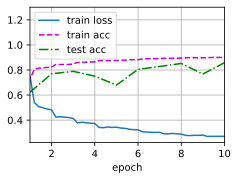

In [25]:
d2l.train_ch6(net2, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

#### BatchNormalization适合比较深的神经网络，当神经网络比较浅的时候就不再适用了